In [1]:
#pip install scikit-learn==1.4.2

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.utils import indexable, _safe_indexing

from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
import os
# import missingpy as missingpy
import sklearn
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

In [3]:
# Set seed value
seed_value = 2024
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)


In [4]:
df= pd.read_csv('credit_card.csv')
data=df.copy

### Three columns  are removed from this file- clientnum, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 and Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2

In [5]:
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [6]:
df.rename(columns = {'Attrition_Flag': 'target'},inplace = True)

In [7]:
df.target.unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

#### In order to feed the data to any machine learning method, it's convenient to change strings to numeric values. So, we are going to change 'Existing' to 0 and 'Attrited' to 1

In [8]:
df['target'].replace({'Existing Customer': 0, 'Attrited Customer' : 1},inplace = True)


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.isnull().sum()

target                      0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [11]:
df.shape

(10127, 20)

# Remove unknown observations

In [12]:
for cols in ['Education_Level', 'Marital_Status', 'Income_Category']:
    df = df.loc[~df[cols].isin(['Unknown', 'unknown'])]


In [13]:
Counter(df.target)

Counter({0: 5968, 1: 1113})

In [14]:
df.columns

Index(['target', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [15]:
df.shape

(7081, 20)

print('The number of normal transactions : ' + str(sum(y_train_new.target == 0)))
print('The number of frauds : ' + str(sum(y_train_new.target == 1)))
print('The percentage of fraud of all transactions : ' + str(float(sum(y_train_new.target == 1))/float(len(y_train_new.target))*100.0))

In [16]:
df_t1 = df.loc[df['target'] == 1].head(500)
df_t2 = df.loc[df['target'] == 0]
df = df_t1.append(df_t2)

# Create helper functions

In [17]:
## evaluate function generates the classification report of the loaded model based on the list of x and y values

def evaluate(x, y, threshold):
    x = np.array(x)
    y = np.ravel(y)
    pred = (loaded_model.predict_proba(x)[:,1] >= threshold).astype(bool)
    print(pd.crosstab(y, pred, rownames=['Actual'], colnames=['Predicted']))
    print(classification_report(y, pred,digits=4))
    return None;


## generate_curves function creates ROC-AUC and PR-AUC curve of the loaded model and compare that wth the random classifier

def generate_curves(filename_old, filename_new, X_test, y_test):   

    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    loaded_model_old = pickle.load(open(filename_old, 'rb'))
    loaded_model_new = pickle.load(open(filename_new, 'rb'))

    test_prob_old = loaded_model_old.predict_proba(X_test)[:, 1]
    test_prob_new = loaded_model_new.predict_proba(X_test)[:, 1]
    
    fpr_old, tpr_old, _ = roc_curve(y_test,  test_prob_old)
    roc_auc_old = roc_auc_score(y_test,  test_prob_old)
    ax1.plot([0, 1], [0, 1], linestyle='--',label ='random, auc = %.4f'% 0.5, c = 'blue')
    ax1.plot(fpr_old, tpr_old ,label ='SMOTE-NC, auc = %.4f'% roc_auc_old, c= 'green')
    
    fpr_new, tpr_new, _ = roc_curve(y_test,  test_prob_new)
    roc_auc_new = roc_auc_score(y_test,  test_prob_new)
    ax1.plot(fpr_new, tpr_new ,label ='SMOTE-ENC, auc = %.4f'% roc_auc_new, c= 'red')
    
    ax1.legend(loc=4)

    ax1.set_title('ROC curve' ,fontsize=16)
    ax1.set_ylabel('True Positive Rate',fontsize=14)
    ax1.set_xlabel('False Positive Rate',fontsize=14)

    ax2 = f.add_subplot(122)
    

    precision_old, recall_old, _ = precision_recall_curve(y_test, test_prob_old)
    precision_new, recall_new, _ = precision_recall_curve(y_test, test_prob_new)
    
    auc_score_old = auc(recall_old, precision_old)
    auc_score_new = auc(recall_new, precision_new)
    
    random_auc = y_test.sum()/len(y_test)
    
    ax2.plot([0, 1], [random_auc, random_auc], linestyle='--', label ='random, auc = %.4f'% random_auc, c ='blue')
    ax2.plot(recall_old, precision_old, label = 'SMOTE-NC, auc=%.4f'% auc_score_old, c = 'green')
    ax2.plot(recall_new, precision_new, label = 'SMOTE-ENC, auc=%.4f'% auc_score_new, c = 'red')
    
    ax2.set_title('Precision Recall curve' ,fontsize=16)
    ax2.set_ylabel('Precision', fontsize=14)
    ax2.set_xlabel('Recall',fontsize=14)
    ax2.legend(loc='best')
    plt.show()
    f.savefig(REPORTS / 'ccard_roc_prc.jpeg', bbox_inches='tight')
    
    return None;

In [18]:
## Split the data to be 5-fold cross-validated
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#randomforest model - hyperparameter tuning using grid search

param_grid = {
'max_depth': [4, 5, 6], 'max_features': [3, 5],
'min_samples_leaf': [2, 3], 'min_samples_split': [4, 5], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}

In [19]:
## Replace Male with 0 and Female with 1
df['Gender'].replace({'M': 0, 'F': 1},inplace = True)

In [20]:
Counter(df.target)

Counter({0: 5968, 1: 500})

# Num of minority instances is 500 and majority instances is 5968

In [21]:
df.columns

Index(['target', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [22]:
# df_feature= df.drop(['target'],1)
# df_target= df[['target']]

In [23]:
# Label encode categorical variables

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [24]:
df.columns

Index(['target', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [25]:
encoded_df = MultiColumnLabelEncoder(columns = ['Education_Level', 'Marital_Status', 
                                                'Income_Category', 'Card_Category']).fit_transform(df)


In [26]:
## Check if categorical variables and the target has some correlation

anovap_value = list()
for cols in ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']:
    statistic, p = stats.f_oneway(encoded_df[cols], encoded_df['target'])
    anovap_value.append(tuple([cols, p]))
    
print(anovap_value)

[('Gender', 0.0), ('Education_Level', 0.0), ('Marital_Status', 0.0), ('Income_Category', 0.0), ('Card_Category', 9.292702718255405e-29)]


In [27]:
from scipy.stats import chi2_contingency
chi2p_value = list()
for cols in ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']:
    obs = pd.crosstab(encoded_df[cols], encoded_df['target'])
    g, p, dof, expctd = chi2_contingency(obs)
    chi2p_value.append(tuple([cols, p]))
    
print(chi2p_value)

[('Gender', 0.058843486727238416), ('Education_Level', 0.04097165799983772), ('Marital_Status', 0.12227261153702998), ('Income_Category', 0.23228068911971209), ('Card_Category', 0.5613422371115786)]


In [28]:
#encoded_df.to_csv('cleaned.csv')

In [29]:
X= encoded_df.drop(['target'],1)
y= df[['target']]

In [30]:
# Split the raw data into train and test set. Split ratio = 75:25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [31]:
col_list = list(X_train.columns)
X_train.index = pd.RangeIndex(len(X_train.index))
y_train.index = pd.RangeIndex(len(y_train.index))
X_test.index = pd.RangeIndex(len(X_test.index))
y_test.index = pd.RangeIndex(len(y_test.index))

In [32]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [33]:
X_train = pd.DataFrame(X_train, index=range(X_train.shape[0]),
                          columns=col_list)
X_test = pd.DataFrame(X_test, index=range(X_test.shape[0]),
                          columns=col_list)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

## without resampling applied

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score,accuracy_score,f1_score, cohen_kappa_score
from imblearn.metrics import sensitivity_score,specificity_score


knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train ,y_train)
knn_pred = knn_model.predict(X_test)

PRESC = precision_score(y_test, knn_pred)
ACC = accuracy_score(y_test, knn_pred)
F1 = f1_score(y_test, knn_pred)
KAPPA = cohen_kappa_score(y_test, knn_pred)
AUC = roc_auc_score(y_test, knn_pred)
SNS = sensitivity_score(y_test, knn_pred)
SPS = specificity_score(y_test, knn_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)

PRECISION:  0.7209302325581395
ACCURACY:  0.9338280766852195
F1:  0.3668639053254438
KAPPA:  0.3407217732255742
AUC:  0.6189917281466577
SENSITIVITY:  0.24603174603174602
SPECIFICITY:  0.9919517102615694


In [36]:
ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

knn_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
knn_overall.insert(0, 'without resampling applied', 'KNN')
knn_overall

,without resampling applied,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,KNN,0.72093,0.933828,0.366864,0.340722,0.618992,0.246032,0.991952


In [37]:
#DT
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9554730983302412


In [38]:


PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

dt_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
dt_overall.insert(0, 'without resampling applied', 'DT')
dt_overall

PRECISION:  0.7045454545454546
ACCURACY:  0.9554730983302412
F1:  0.7209302325581395
KAPPA:  0.6967509025270757
AUC:  0.8559691482226693
SENSITIVITY:  0.7380952380952381
SPECIFICITY:  0.9738430583501007


,without resampling applied,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,DT,0.704545,0.955473,0.72093,0.696751,0.855969,0.738095,0.973843


In [39]:
#RF
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, np.ravel(y_train))
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9628942486085343


In [40]:


PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

rf_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
rf_overall.insert(0, 'without resampling applied', 'RF')
rf_overall

PRECISION:  0.9024390243902439
ACCURACY:  0.9628942486085343
F1:  0.7115384615384616
KAPPA:  0.6926556679084619
AUC:  0.7909680304046502
SENSITIVITY:  0.5873015873015873
SPECIFICITY:  0.994634473507713


,without resampling applied,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,RF,0.902439,0.962894,0.711538,0.692656,0.790968,0.587302,0.994634


In [41]:
# GNB
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()
bayes.fit(X_train, np.ravel(y_train))
y_pred=bayes.predict(X_test)



In [42]:


PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

gnb_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
gnb_overall.insert(0, 'without resampling applied', ' GNB')
gnb_overall

PRECISION:  0.6213592233009708
ACCURACY:  0.9375386518243661
F1:  0.5589519650655022
KAPPA:  0.5257059218149662
AUC:  0.7408897831433043
SENSITIVITY:  0.5079365079365079
SPECIFICITY:  0.9738430583501007


,without resampling applied,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,GNB,0.621359,0.937539,0.558952,0.525706,0.74089,0.507937,0.973843


In [43]:
#SVM
model_5 = SVC()
model_5.fit(X_train , np.ravel(y_train))
y_pred=model_5.predict(X_test)



In [44]:


PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

svm_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
svm_overall.insert(0, 'without resampling applied', 'SVM')
svm_overall

PRECISION:  0.8518518518518519
ACCURACY:  0.9455782312925171
F1:  0.5111111111111111
KAPPA:  0.48713290947623367
AUC:  0.6798569192935391
SENSITIVITY:  0.36507936507936506
SPECIFICITY:  0.994634473507713


,without resampling applied,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,SVM,0.851852,0.945578,0.511111,0.487133,0.679857,0.365079,0.994634


In [45]:
#XGB
from xgboost import XGBClassifier
thevirus = XGBClassifier(objective = "binary:logistic", random_state = 123)
thevirus.fit(X_train, y_train)
# Predicting the Test set results
y_pred = thevirus.predict(X_test)

In [46]:


PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

xgb_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
xgb_overall.insert(0, 'without resampling applied', 'XGB ')
xgb_overall

PRECISION:  0.8715596330275229
ACCURACY:  0.9721706864564007
F1:  0.8085106382978723
KAPPA:  0.7935902781914577
AUC:  0.8722892913033757
SENSITIVITY:  0.753968253968254
SPECIFICITY:  0.9906103286384976


,without resampling applied,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,XGB,0.87156,0.972171,0.808511,0.79359,0.872289,0.753968,0.99061


In [47]:
import tensorflow as tf
import keras 
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential

In [48]:
model = Sequential()
model.add(Dense(units = 32, input_shape = (19,), activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal', use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(units = 128, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 64, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 8, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dense(units =1 , activation = 'sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                2048      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 128)               8192      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8192      
                                                       

In [49]:
model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.Adam(), metrics = ['acc'])
model.fit(X_train, y_train, batch_size = 32, verbose = 2, epochs = 50)

Epoch 1/50


152/152 - 4s - loss: 0.2640 - acc: 0.9165 - 4s/epoch - 23ms/step
Epoch 2/50
152/152 - 0s - loss: 0.1936 - acc: 0.9266 - 427ms/epoch - 3ms/step
Epoch 3/50
152/152 - 0s - loss: 0.1700 - acc: 0.9373 - 441ms/epoch - 3ms/step
Epoch 4/50
152/152 - 0s - loss: 0.1495 - acc: 0.9435 - 488ms/epoch - 3ms/step
Epoch 5/50
152/152 - 1s - loss: 0.1380 - acc: 0.9448 - 732ms/epoch - 5ms/step
Epoch 6/50
152/152 - 1s - loss: 0.1286 - acc: 0.9462 - 1s/epoch - 7ms/step
Epoch 7/50
152/152 - 1s - loss: 0.1246 - acc: 0.9497 - 883ms/epoch - 6ms/step
Epoch 8/50
152/152 - 1s - loss: 0.1147 - acc: 0.9530 - 1s/epoch - 8ms/step
Epoch 9/50
152/152 - 1s - loss: 0.1044 - acc: 0.9586 - 1s/epoch - 8ms/step
Epoch 10/50
152/152 - 1s - loss: 0.1021 - acc: 0.9551 - 606ms/epoch - 4ms/step
Epoch 11/50
152/152 - 1s - loss: 0.0966 - acc: 0.9641 - 708ms/epoch - 5ms/step
Epoch 12/50
152/152 - 1s - loss: 0.0884 - acc: 0.9670 - 827ms/epoch - 5ms/step
Epoch 13/50
152/152 - 1s - loss: 0.0879 - acc: 0.9652 - 993ms/epoch - 

In [50]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

ann_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
ann_overall.insert(0, 'without resampling applied', 'ANN ')
ann_overall

51/51 [==============================] - 1s 2ms/step
PRECISION:  0.6068376068376068
ACCURACY:  0.9375386518243661
F1:  0.5843621399176955
KAPPA:  0.5506442479921418
AUC:  0.7663201430807064
SENSITIVITY:  0.5634920634920635
SPECIFICITY:  0.9691482226693494


,without resampling applied,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,ANN,0.606838,0.937539,0.584362,0.550644,0.76632,0.563492,0.969148


# Performance comparison

In [51]:
predictions = pd.concat([knn_overall, dt_overall, svm_overall, gnb_overall, xgb_overall,rf_overall,ann_overall], ignore_index=True, sort=False)
predictions

,without resampling applied,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,KNN,0.720930,0.933828,0.366864,0.340722,0.618992,0.246032,0.991952
1,DT,0.704545,0.955473,0.720930,0.696751,0.855969,0.738095,0.973843
2,SVM,0.851852,0.945578,0.511111,0.487133,0.679857,0.365079,0.994634
3,GNB,0.621359,0.937539,0.558952,0.525706,0.740890,0.507937,0.973843
4,XGB,0.871560,0.972171,0.808511,0.793590,0.872289,0.753968,0.990610
5,RF,0.902439,0.962894,0.711538,0.692656,0.790968,0.587302,0.994634
6,ANN,0.606838,0.937539,0.584362,0.550644,0.766320,0.563492,0.969148


## Gsmote

In [52]:
import numpy as np
from sklearn.neighbors import KDTree
from scipy.spatial.distance import euclidean
from sklearn.base import ClassifierMixin

import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.neighbors.base import NeighborsBase

In [53]:
"""Class to perform over-sampling using Geometric SMOTE."""


import numpy as np
from imblearn.utils._validation import _count_class_sample
from numpy.linalg import norm
from sklearn.utils import check_random_state
from imblearn.over_sampling.base import BaseOverSampler
from imblearn.utils import check_neighbors_object, Substitution
from imblearn.utils._docstring import _random_state_docstring
import collections
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


In [54]:
#gsmote

def _make_geometric_sample(
        center, surface_point, truncation_factor, deformation_factor, random_state
):
    

    # Zero radius case
    if np.array_equal(center, surface_point):
        return center

    # Generate a point on the surface of a unit hyper-sphere
    radius = norm(center - surface_point)
    normal_samples = random_state.normal(size=center.size)
    point_on_unit_sphere = normal_samples / norm(normal_samples)
    point = (random_state.uniform(size=1) ** (1 / center.size)) * point_on_unit_sphere

    # Parallel unit vector
    parallel_unit_vector = (surface_point - center) / norm(surface_point - center)

    # Truncation
    close_to_opposite_boundary = (
            truncation_factor > 0
            and np.dot(point, parallel_unit_vector) < truncation_factor - 1
    )
    close_to_boundary = (
            truncation_factor < 0
            and np.dot(point, parallel_unit_vector) > truncation_factor + 1
    )
    if close_to_opposite_boundary or close_to_boundary:
        point -= 2 * np.dot(point, parallel_unit_vector) * parallel_unit_vector

    # Deformation
    parallel_point_position = np.dot(point, parallel_unit_vector) * parallel_unit_vector
    perpendicular_point_position = point - parallel_point_position
    point = (
            parallel_point_position + (1 - deformation_factor) * perpendicular_point_position
    )

    # Translation
    point = center + radius * point

    return point


@Substitution(
    sampling_strategy=BaseOverSampler._sampling_strategy_docstring,
    random_state=_random_state_docstring,
)
class EGSmote(BaseOverSampler):
   

    def __init__(
            self,
            sampling_strategy='auto',
            random_state=None,
            truncation_factor=1.0,
            deformation_factor=0.0,
            k_neighbors=5,
            n_jobs=1,
            sampling_rate=0.25,
    ):
        super(EGSmote, self).__init__(sampling_strategy=sampling_strategy)
        self.random_state = random_state
        self.truncation_factor = truncation_factor
        self.deformation_factor = deformation_factor
        self.k_neighbors = k_neighbors
        self.n_jobs = n_jobs
        self.sampling_rate = sampling_rate

    def _validate_estimator(self):
        """Create the necessary attributes for Geometric SMOTE."""

        # Check random state
        self.random_state_ = check_random_state(self.random_state)
        # Create nearest neighbors object for mixed class
        self.nn_mix_ = check_neighbors_object('nns_mixed', self.k_neighbors)
        # Create nearest neighbors of positive class
        self.nns_pos_ = check_neighbors_object('nns_positive', self.k_neighbors, additional_neighbor=1)
        self.nns_pos_.set_params(n_jobs=self.n_jobs)
        # Create nearest neighbors of negative class
        self.nn_neg_ = check_neighbors_object('nn_negative', nn_object=1)
        self.nn_neg_.set_params(n_jobs=self.n_jobs)

    def _make_geometric_samples(self, X, y, pos_class_label, n_samples):
        
        # Return zero new samples
        if n_samples == 0:
            return (
                np.array([], dtype=X.dtype).reshape(0, X.shape[1]),
                np.array([], dtype=y.dtype),
            )
        # Select positive class samples
        X_pos = X[y == pos_class_label]

        # Oversampling limit for minority class
        subCluster_label, sampling_limitation = self.sub_clustering(X_pos, n_samples)

        # Get positive k_nearest points
        self.nns_pos_.fit(X_pos)
        points_pos = self.nns_pos_.kneighbors(X_pos)[1][:, 1:]
        samples_indices = self.random_state_.randint(low=0, high=len(points_pos.flatten()), size=n_samples)
        rows = np.floor_divide(samples_indices, points_pos.shape[1])
        cols = np.mod(samples_indices, points_pos.shape[1])

        # Get negative k_nearest points
        X_neg = X[y != pos_class_label]
        self.nn_neg_.fit(X_neg)
        points_neg = self.nn_neg_.kneighbors(X_pos)[1]

        # Get combined neighbours
        self.nn_mix_.fit(X)
        points_mix = self.nn_mix_.kneighbors(X_pos)[1]

        # Generate new samples
        X_new = np.zeros((n_samples, X.shape[1]))
        for ind, (row, col) in enumerate(zip(rows, cols)):
            created = False
            while not created:
                proceed = True

                # Define center point
                center = X_pos[row]

                # count the number of k-nearest minority points
                count_min = 0
                for index in points_mix[row]:
                    if y[index] == pos_class_label:
                        count_min = count_min + 1

                # check noisy point
                if count_min != 0:

                    # Minority strategy
                    if count_min == points_mix.shape[1]:
                        remaining_limitation = sampling_limitation[subCluster_label[row]]
                        # check whether new node can be created or not
                        if remaining_limitation > 0:
                            sampling_limitation[subCluster_label[row]] = remaining_limitation - 1
                            surface_point = X_pos[points_pos[row, col]]
                            self.truncation_factor = 1.0
                        else:
                            proceed = False
                            row = self.random_state_.randint(low=0, high=len(X_pos), size=1)[0]

                    # Combined strategy
                    else:
                        surface_point_pos = X_pos[points_pos[row, col]]
                        surface_point_neg = X_neg[points_neg[row, 0]]
                        radius_pos = norm(center - surface_point_pos)
                        radius_neg = norm(center - surface_point_neg)
                        surface_point = (
                            surface_point_neg if radius_pos > radius_neg else surface_point_pos
                        )
                        if radius_pos > radius_neg:
                            self.truncation_factor = -1.0
                        else:
                            self.truncation_factor = 0.4

                    # Append new sample
                    if proceed:
                        X_new[ind] = _make_geometric_sample(
                            center,
                            surface_point,
                            self.truncation_factor,
                            self.deformation_factor,
                            self.random_state_,
                        )
                        created = True
                else:
                    row = self.random_state_.randint(low=0, high=len(X_pos), size=1)[0]

        # Create new samples for target variable
        y_new = np.array([pos_class_label] * len(samples_indices))
        return X_new, y_new

    # Handles sub clustering to create synthetic data
    def sub_clustering(self, X_pos, n_samples):

        # Find efficient number of clusters
        model = KMeans()
        visualizer = KElbowVisualizer(model, k=(3, 20))
        visualizer.fit(X_pos)  # Fit the data to the visualizer
        num_clusters = visualizer.elbow_value_

        # synthetic samples created under minority strategy
        num_samples = n_samples * 0.4
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(X_pos)
        y_kmeans = kmeans.predict(X_pos)
        clusters = []
        range_oversample = []

        # Iterate through sub-clusters
        for i in range(num_clusters):
            cluster = X_pos[y_kmeans == i]
            clusters.append(cluster)
            range_oversample.append(int(len(cluster) * (num_samples / len(X_pos))))
        return y_kmeans, range_oversample

    def _fit_resample(self, X, y):
        # Validate estimator's parameters
        self._validate_estimator()
        # Copy data
        X_resampled, y_resampled = X.copy(), y.copy()
        # Resample data
        for class_label, n_samples in self.min_oversample(y).items():
            if n_samples < 0:
                n_samples = 0
            # Apply gsmote mechanism
            X_new, y_new = self._make_geometric_samples(X, y, class_label, n_samples)

            # Append new data
            X_resampled, y_resampled = (
                np.vstack((X_resampled, X_new)),
                np.hstack((y_resampled, y_new)),
            )

        return X_resampled, y_resampled

    # find number of minority samples to generate
    def min_oversample(self, y):
        target_stats = _count_class_sample(y)
        n_sample_majority = max(target_stats.values())
        class_minority = min(target_stats, key=target_stats.get)

        sampling_strategy = {
            key: int(n_sample_majority * (self.sampling_rate / (1 - self.sampling_rate))) - value
            for (key, value) in target_stats.items()
            if key == class_minority
        }
        sampling_strategy = collections.OrderedDict(sampling_strategy)
        return sampling_strategy


Resampled dataset shape Counter({'target': 1})


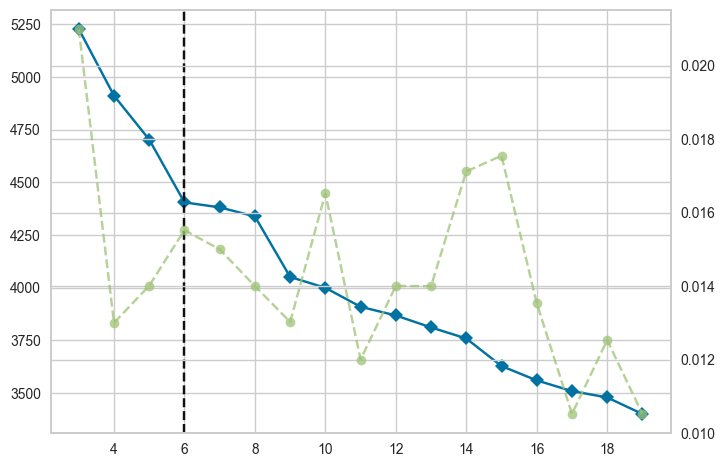

In [55]:
"""Demonstration of resampling"""

import pandas as pd

#from Experiment.visualizer import visualize
#from egsmote import EGSmote
from collections import Counter
import numpy as np



egsmote = EGSmote(sampling_rate=0.25)
X_res, y_res = egsmote.fit_resample(X_train, y_train)
#X_S_ENC, y_S_ENC

print('Resampled dataset shape %s' % (Counter(y_res)))
# Resampled dataset shape Counter({{0: 28416, 1: 9472}})

#visualize(X,y,X_res,y_res)
# Visualize the resampled data - check output folder

In [56]:
col_list = list(X_train.columns)
col_list

['Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [57]:
X_train_new = pd.DataFrame(X_res, index=range(X_res.shape[0]),
                          columns=col_list)
y_train_new= pd.DataFrame(y_res)



In [58]:
print('The number of normal transactions : ' + str(sum(y_train_new.target == 0)))
print('The number of frauds : ' + str(sum(y_train_new.target == 1)))
print('The percentage of fraud of all transactions : ' + str(float(sum(y_train_new.target == 1))/float(len(y_train_new.target))*100.0))

The number of normal transactions : 4477
The number of frauds : 1492
The percentage of fraud of all transactions : 24.995811693751047


In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score,accuracy_score,f1_score, cohen_kappa_score
from imblearn.metrics import sensitivity_score,specificity_score


knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_new ,y_train_new)
knn_pred = knn_model.predict(X_test)

PRESC = precision_score(y_test, knn_pred)
ACC = accuracy_score(y_test, knn_pred)
F1 = f1_score(y_test, knn_pred)
KAPPA = cohen_kappa_score(y_test, knn_pred)
AUC = roc_auc_score(y_test, knn_pred)
SNS = sensitivity_score(y_test, knn_pred)
SPS = specificity_score(y_test, knn_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY", SNS)
print("SPECIFICITY: ", SPS)

PRECISION:  0.6805555555555556
ACCURACY:  0.9381570810142239
F1:  0.494949494949495
KAPPA:  0.4646085384508414
AUC:  0.6867315001117817
SENSITIVITY 0.3888888888888889
SPECIFICITY:  0.9845741113346748


In [60]:
ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

knn_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
knn_overall.insert(0, 'with gsmote only', 'KNN')
knn_overall

,with gsmote only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,KNN,0.680556,0.938157,0.494949,0.464609,0.686732,0.388889,0.984574


In [61]:
#DT
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_new ,y_train_new)

y_pred = clf.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

dt_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
dt_overall.insert(0, 'with gsmote only', 'DT')
dt_overall

PRECISION:  0.6511627906976745
ACCURACY:  0.9461966604823747
F1:  0.6588235294117647
KAPPA:  0.6296234864820036
AUC:  0.8182427900737759
SENSITIVITY:  0.6666666666666666
SPECIFICITY:  0.9698189134808853


,with gsmote only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,DT,0.651163,0.946197,0.658824,0.629623,0.818243,0.666667,0.969819


In [62]:
#RF
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_new ,np.ravel(y_train_new))
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

rf_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
rf_overall.insert(0, 'with gsmote only', 'RF')
rf_overall

PRECISION:  0.9021739130434783
ACCURACY:  0.9678416821273964
F1:  0.7614678899082569
KAPPA:  0.7446754240530544
AUC:  0.8263469707131678
SENSITIVITY:  0.6587301587301587
SPECIFICITY:  0.993963782696177


,with gsmote only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,RF,0.902174,0.967842,0.761468,0.744675,0.826347,0.65873,0.993964


In [63]:
# GNB
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()
bayes.fit(X_train_new ,np.ravel(y_train_new))
y_pred=bayes.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

gnb_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
gnb_overall.insert(0, 'with gsmote only', ' GNB')
gnb_overall

PRECISION:  0.422680412371134
ACCURACY:  0.9035250463821892
F1:  0.5125
KAPPA:  0.4616349946217282
AUC:  0.787838139950816
SENSITIVITY:  0.6507936507936508
SPECIFICITY:  0.9248826291079812


,with gsmote only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,GNB,0.42268,0.903525,0.5125,0.461635,0.787838,0.650794,0.924883


In [64]:
#SVM
model_5 = SVC()
model_5.fit(X_train_new ,np.ravel(y_train_new))
y_pred=model_5.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

svm_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
svm_overall.insert(0, 'with gsmote only', 'SVM')
svm_overall

PRECISION:  0.6964285714285714
ACCURACY:  0.9492888064316636
F1:  0.6554621848739496
KAPPA:  0.6281945589447651
AUC:  0.7981220657276996
SENSITIVITY:  0.6190476190476191
SPECIFICITY:  0.97719651240778


,with gsmote only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,SVM,0.696429,0.949289,0.655462,0.628195,0.798122,0.619048,0.977197


In [65]:
#XGB
from xgboost import XGBClassifier
thevirus = XGBClassifier(objective = "binary:logistic", random_state = 123)
thevirus.fit(X_train_new ,np.ravel(y_train_new))
# Predicting the Test set results
y_pred = thevirus.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

xgb_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
xgb_overall.insert(0, 'with gsmote only', 'XGB ')
xgb_overall

PRECISION:  0.8807339449541285
ACCURACY:  0.9734075448361162
F1:  0.8170212765957446
KAPPA:  0.8027640436051706
AUC:  0.8765928906773978
SENSITIVITY:  0.7619047619047619
SPECIFICITY:  0.9912810194500336


,with gsmote only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,XGB,0.880734,0.973408,0.817021,0.802764,0.876593,0.761905,0.991281


In [66]:
model = Sequential()
model.add(Dense(units = 32, input_shape = (19,), activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal', use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(units = 128, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 64, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 8, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dense(units =1 , activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                640       
                                                                 
 dense_9 (Dense)             (None, 64)                2048      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 128)               8192      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8192      
                                                      

In [67]:
model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.Adam(), metrics = ['acc'])
model.fit(X_train_new ,np.ravel(y_train_new), batch_size = 32, verbose = 2, epochs = 50)

Epoch 1/50
187/187 - 2s - loss: 0.4669 - acc: 0.7804 - 2s/epoch - 13ms/step
Epoch 2/50
187/187 - 0s - loss: 0.3029 - acc: 0.8725 - 499ms/epoch - 3ms/step
Epoch 3/50
187/187 - 1s - loss: 0.2698 - acc: 0.8869 - 505ms/epoch - 3ms/step
Epoch 4/50
187/187 - 0s - loss: 0.2396 - acc: 0.9003 - 490ms/epoch - 3ms/step
Epoch 5/50
187/187 - 1s - loss: 0.2327 - acc: 0.9037 - 514ms/epoch - 3ms/step
Epoch 6/50
187/187 - 0s - loss: 0.2134 - acc: 0.9120 - 500ms/epoch - 3ms/step
Epoch 7/50
187/187 - 0s - loss: 0.1955 - acc: 0.9218 - 481ms/epoch - 3ms/step
Epoch 8/50
187/187 - 0s - loss: 0.1848 - acc: 0.9221 - 483ms/epoch - 3ms/step
Epoch 9/50
187/187 - 1s - loss: 0.1759 - acc: 0.9275 - 500ms/epoch - 3ms/step
Epoch 10/50
187/187 - 0s - loss: 0.1620 - acc: 0.9352 - 498ms/epoch - 3ms/step
Epoch 11/50
187/187 - 1s - loss: 0.1591 - acc: 0.9352 - 510ms/epoch - 3ms/step
Epoch 12/50
187/187 - 1s - loss: 0.1368 - acc: 0.9435 - 506ms/epoch - 3ms/step
Epoch 13/50
187/187 - 1s - loss: 0.1378 - acc: 0.9445 - 504ms/e

In [68]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

ann_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
ann_overall.insert(0, 'with gsmote only', 'ANN ')
ann_overall

51/51 [==============================] - 0s 2ms/step
PRECISION:  0.6033057851239669
ACCURACY:  0.9375386518243661
F1:  0.5910931174089069
KAPPA:  0.5572949279899813
AUC:  0.7735859602056786
SENSITIVITY:  0.5793650793650794
SPECIFICITY:  0.9678068410462777


,with gsmote only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,ANN,0.603306,0.937539,0.591093,0.557295,0.773586,0.579365,0.967807


In [69]:
predictions = pd.concat([knn_overall, dt_overall, svm_overall, gnb_overall, xgb_overall,rf_overall,ann_overall], ignore_index=True, sort=False)
predictions

,with gsmote only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,KNN,0.680556,0.938157,0.494949,0.464609,0.686732,0.388889,0.984574
1,DT,0.651163,0.946197,0.658824,0.629623,0.818243,0.666667,0.969819
2,SVM,0.696429,0.949289,0.655462,0.628195,0.798122,0.619048,0.977197
3,GNB,0.422680,0.903525,0.512500,0.461635,0.787838,0.650794,0.924883
4,XGB,0.880734,0.973408,0.817021,0.802764,0.876593,0.761905,0.991281
5,RF,0.902174,0.967842,0.761468,0.744675,0.826347,0.658730,0.993964
6,ANN,0.603306,0.937539,0.591093,0.557295,0.773586,0.579365,0.967807


# gSMOTE+ SMOTEENN

In [70]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state=1)
X_resampled, y_resampled = sm.fit_resample(X_train_new, y_train_new)

In [71]:
X_train_gs_sn = pd.DataFrame(X_resampled, index=range(X_resampled.shape[0]),
                          columns=col_list)
y_train_gs_sn= pd.DataFrame(y_resampled)

In [72]:
print('The number of normal transactions : ' + str(sum(y_train_gs_sn.target == 0)))
print('The number of frauds : ' + str(sum(y_train_gs_sn.target == 1)))
print('The percentage of fraud of all transactions : ' + str(float(sum(y_train_gs_sn.target == 1))/float(len(y_train_gs_sn.target))*100.0))

The number of normal transactions : 3885
The number of frauds : 4441
The percentage of fraud of all transactions : 53.3389382656738


models

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score,accuracy_score,f1_score, cohen_kappa_score
from imblearn.metrics import sensitivity_score,specificity_score


knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_gs_sn ,np.ravel(y_train_gs_sn))
knn_pred = knn_model.predict(X_test)

PRESC = precision_score(y_test, knn_pred)
ACC = accuracy_score(y_test, knn_pred)
F1 = f1_score(y_test, knn_pred)
KAPPA = cohen_kappa_score(y_test, knn_pred)
AUC = roc_auc_score(y_test, knn_pred)
SNS = sensitivity_score(y_test, knn_pred)
SPS = specificity_score(y_test, knn_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)

PRECISION:  0.341991341991342
ACCURACY:  0.8769325912183055
F1:  0.4425770308123249
KAPPA:  0.3800623052959502
AUC:  0.7625195618153364
SENSITIVITY:  0.626984126984127
SPECIFICITY:  0.898054996646546


In [75]:
ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

knn_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
knn_overall.insert(0, 'gSMOTE+ SMOTEENN', 'KNN')
knn_overall

,gSMOTE+ SMOTEENN,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,KNN,0.341991,0.876933,0.442577,0.380062,0.76252,0.626984,0.898055


In [76]:
#DT
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_gs_sn ,np.ravel(y_train_gs_sn))

y_pred = clf.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

dt_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
dt_overall.insert(0, 'gSMOTE+ SMOTEENN', 'DT')
dt_overall

PRECISION:  0.6013513513513513
ACCURACY:  0.9406307977736549
F1:  0.6496350364963503
KAPPA:  0.6174309077735224
AUC:  0.8333892242342947
SENSITIVITY:  0.7063492063492064
SPECIFICITY:  0.960429242119383


,gSMOTE+ SMOTEENN,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,DT,0.601351,0.940631,0.649635,0.617431,0.833389,0.706349,0.960429


In [77]:
#RF
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_gs_sn ,np.ravel(y_train_gs_sn))
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

rf_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
rf_overall.insert(0, 'gSMOTE+ SMOTEENN', 'RF')
rf_overall

PRECISION:  0.7815126050420168
ACCURACY:  0.9635126777983921
F1:  0.7591836734693878
KAPPA:  0.739462063428342
AUC:  0.8603286384976526
SENSITIVITY:  0.7380952380952381
SPECIFICITY:  0.9825620389000671


,gSMOTE+ SMOTEENN,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,RF,0.781513,0.963513,0.759184,0.739462,0.860329,0.738095,0.982562


In [78]:
# GNB
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()
bayes.fit(X_train_gs_sn ,np.ravel(y_train_gs_sn))
y_pred=bayes.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

gnb_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
gnb_overall.insert(0, 'gSMOTE+ SMOTEENN', ' GNB')
gnb_overall

PRECISION:  0.22657952069716775
ACCURACY:  0.766852195423624
F1:  0.35555555555555557
KAPPA:  0.2657763613830083
AUC:  0.7936507936507936
SENSITIVITY:  0.8253968253968254
SPECIFICITY:  0.7619047619047619


,gSMOTE+ SMOTEENN,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,GNB,0.22658,0.766852,0.355556,0.265776,0.793651,0.825397,0.761905


In [79]:
#SVM
model_5 = SVC()
model_5.fit(X_train_gs_sn ,np.ravel(y_train_gs_sn))
y_pred=model_5.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

svm_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
svm_overall.insert(0, 'gSMOTE+ SMOTEENN', 'SVM')
svm_overall

PRECISION:  0.42543859649122806
ACCURACY:  0.9010513296227582
F1:  0.5480225988700564
KAPPA:  0.49759399722697983
AUC:  0.8409903867650347
SENSITIVITY:  0.7698412698412699
SPECIFICITY:  0.9121395036887995


,gSMOTE+ SMOTEENN,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,SVM,0.425439,0.901051,0.548023,0.497594,0.84099,0.769841,0.91214


In [80]:
#XGB
from xgboost import XGBClassifier
thevirus = XGBClassifier(objective = "binary:logistic", random_state = 123)
thevirus.fit(X_train_gs_sn ,np.ravel(y_train_gs_sn))
# Predicting the Test set results
y_pred = thevirus.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

xgb_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
xgb_overall.insert(0, 'gSMOTE+ SMOTEENN', 'XGB ')
xgb_overall

PRECISION:  0.7923076923076923
ACCURACY:  0.969078540507112
F1:  0.8046875
KAPPA:  0.7879021595416483
AUC:  0.8996758327744243
SENSITIVITY:  0.8174603174603174
SPECIFICITY:  0.9818913480885312


,gSMOTE+ SMOTEENN,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,XGB,0.792308,0.969079,0.804688,0.787902,0.899676,0.81746,0.981891


In [81]:
model = Sequential()
model.add(Dense(units = 32, input_shape = (19,), activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal', use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(units = 128, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 64, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 8, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dense(units =1 , activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                640       
                                                                 
 dense_17 (Dense)            (None, 64)                2048      
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 128)               8192      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8192      
                                                      

In [82]:
model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.Adam(), metrics = ['acc'])
model.fit(X_train_gs_sn ,np.ravel(y_train_gs_sn), batch_size = 32, verbose = 2, epochs = 50)

Epoch 1/50
261/261 - 3s - loss: 0.4311 - acc: 0.7819 - 3s/epoch - 13ms/step
Epoch 2/50
261/261 - 1s - loss: 0.2470 - acc: 0.8984 - 900ms/epoch - 3ms/step
Epoch 3/50
261/261 - 1s - loss: 0.1882 - acc: 0.9247 - 688ms/epoch - 3ms/step
Epoch 4/50
261/261 - 1s - loss: 0.1632 - acc: 0.9385 - 684ms/epoch - 3ms/step
Epoch 5/50
261/261 - 1s - loss: 0.1390 - acc: 0.9468 - 674ms/epoch - 3ms/step
Epoch 6/50
261/261 - 1s - loss: 0.1175 - acc: 0.9575 - 703ms/epoch - 3ms/step
Epoch 7/50
261/261 - 1s - loss: 0.1072 - acc: 0.9613 - 760ms/epoch - 3ms/step
Epoch 8/50
261/261 - 1s - loss: 0.0945 - acc: 0.9672 - 682ms/epoch - 3ms/step
Epoch 9/50
261/261 - 1s - loss: 0.0854 - acc: 0.9706 - 707ms/epoch - 3ms/step
Epoch 10/50
261/261 - 1s - loss: 0.0852 - acc: 0.9707 - 650ms/epoch - 2ms/step
Epoch 11/50
261/261 - 1s - loss: 0.0736 - acc: 0.9737 - 664ms/epoch - 3ms/step
Epoch 12/50
261/261 - 1s - loss: 0.0651 - acc: 0.9756 - 750ms/epoch - 3ms/step
Epoch 13/50
261/261 - 1s - loss: 0.0701 - acc: 0.9749 - 791ms/e

In [83]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

ann_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
ann_overall.insert(0, 'gSMOTE+ SMOTEENN', 'ANN ')
ann_overall

51/51 [==============================] - 0s 2ms/step
PRECISION:  0.4946236559139785
ACCURACY:  0.9208410636982065
F1:  0.5897435897435898
KAPPA:  0.5477239353891337
AUC:  0.8335568969371787
SENSITIVITY:  0.7301587301587301
SPECIFICITY:  0.9369550637156271


,gSMOTE+ SMOTEENN,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,ANN,0.494624,0.920841,0.589744,0.547724,0.833557,0.730159,0.936955


In [84]:
predictions = pd.concat([knn_overall, dt_overall, svm_overall, gnb_overall, xgb_overall,rf_overall,ann_overall], ignore_index=True, sort=False)
predictions

,gSMOTE+ SMOTEENN,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,KNN,0.341991,0.876933,0.442577,0.380062,0.762520,0.626984,0.898055
1,DT,0.601351,0.940631,0.649635,0.617431,0.833389,0.706349,0.960429
2,SVM,0.425439,0.901051,0.548023,0.497594,0.840990,0.769841,0.912140
3,GNB,0.226580,0.766852,0.355556,0.265776,0.793651,0.825397,0.761905
4,XGB,0.792308,0.969079,0.804688,0.787902,0.899676,0.817460,0.981891
5,RF,0.781513,0.963513,0.759184,0.739462,0.860329,0.738095,0.982562
6,ANN,0.494624,0.920841,0.589744,0.547724,0.833557,0.730159,0.936955


## GSMOTEENN

X_res shape: (4875, 19)
X_res_cleaned shape: (4875, 19)
y_res_cleaned shape: (4875,)


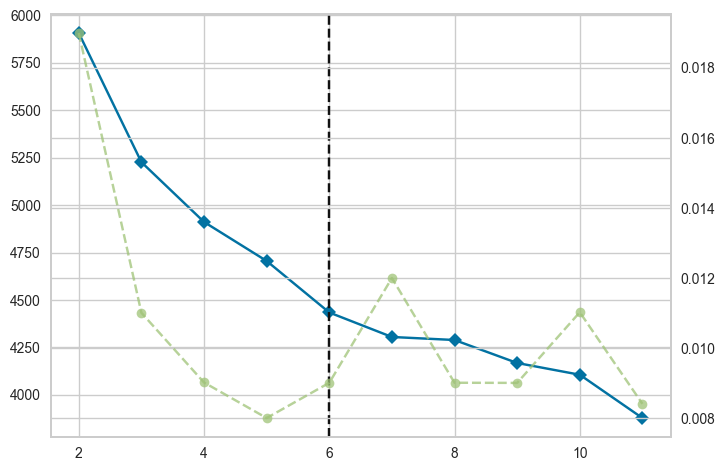

In [85]:
import numpy as np
from sklearn.impute import SimpleImputer
from imblearn.utils._validation import _count_class_sample
from sklearn.utils import check_random_state
from imblearn.over_sampling.base import BaseOverSampler
from imblearn.utils import check_neighbors_object, Substitution
from imblearn.utils._docstring import _random_state_docstring
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.base import ClassifierMixin
from sklearn.neighbors import KDTree
from numpy.linalg import norm

# Function to generate geometric samples
def _make_geometric_sample(
        center, surface_point, truncation_factor, deformation_factor, random_state
):
    if np.array_equal(center, surface_point):
        return center

    radius = norm(center - surface_point)
    normal_samples = random_state.normal(size=center.size)
    point_on_unit_sphere = normal_samples / norm(normal_samples)
    point = (random_state.uniform(size=1) ** (1 / center.size)) * point_on_unit_sphere

    parallel_unit_vector = (surface_point - center) / norm(surface_point - center)

    close_to_opposite_boundary = (
            truncation_factor > 0
            and np.dot(point, parallel_unit_vector) < truncation_factor - 1
    )
    close_to_boundary = (
            truncation_factor < 0
            and np.dot(point, parallel_unit_vector) > truncation_factor + 1
    )
    if close_to_opposite_boundary or close_to_boundary:
        point -= 2 * np.dot(point, parallel_unit_vector) * parallel_unit_vector

    parallel_point_position = np.dot(point, parallel_unit_vector) * parallel_unit_vector
    perpendicular_point_position = point - parallel_point_position
    point = (
            parallel_point_position + (1 - deformation_factor) * perpendicular_point_position
    )

    point = center + radius * point

    return point

# ENN class
class ENN(ClassifierMixin):
    def __init__(self, k=3, distance_function=lambda x, y: norm(x - y)):
        self.k = k
        self.distance_function = distance_function

    def buildDistanceMap(self, X, Y):
        classes = np.unique(Y)
        nClasses = len(classes)
        tree = KDTree(X)
        nRows = X.shape[0]

        TSOri = np.array([]).reshape(0, self.k)

        distanceMap = np.array([]).reshape(0, self.k)
        labels = np.array([]).reshape(0, self.k)

        for row in range(nRows):
            distances, indicesOfNeighbors = tree.query(X[row].reshape(1, -1), k=self.k + 1)

            distances = distances[0][1:]
            indicesOfNeighbors = indicesOfNeighbors[0][1:]

            distanceMap = np.append(distanceMap, np.array(distances).reshape(1, self.k), axis=0)
            labels = np.append(labels, np.array(Y[indicesOfNeighbors]).reshape(1, self.k), axis=0)

        for c in classes:
            nTraining = np.sum(Y == c)
            labelTmp = labels[Y.ravel() == c, :]

            tmpKNNClass = labelTmp.ravel()
            TSOri = np.append(TSOri, len(tmpKNNClass[tmpKNNClass == c]) / (nTraining * float(self.k)))

        return distanceMap, labels, TSOri

    def fit(self, X, Y):
        self.Y_train = Y
        self.X_train = X

        self.knnDistances, self.knnLabels, self.TSOri = self.buildDistanceMap(X, Y)

        self.classes = np.unique(Y)
        self.nClasses = len(self.classes)

        self.nTrainingEachClass = []
        for i, c in enumerate(self.classes):
            self.nTrainingEachClass.append(len(Y[Y == c]))

    def predict(self, X):
        y_pred = []

        for testingData in X:
            disNorm2 = []
            for row in self.X_train:
                dist = self.distance_function(row, testingData)
                disNorm2.append(dist)

            disNorm2 = np.array(disNorm2)
            sortIX = np.argsort(disNorm2)

            classNNTest = self.Y_train[sortIX][:self.k]

            hitNumKNN = []
            for c in self.classes:
                hitNumKNN.append(np.sum(classNNTest == c))

            TSENN = [0] * self.nClasses
            nTrainingNN = [0] * self.nClasses
            nSameTrainingNN = [0] * self.nClasses

            for i, c in enumerate(self.classes):
                mask = self.Y_train.ravel() == c
                testingMuDist = disNorm2[mask]
                trainingMuDist = self.knnDistances[mask][:, self.k - 1]
                trainingMuClass = self.knnLabels[mask][:, self.k - 1]
                difDist = testingMuDist - trainingMuDist

                C = difDist <= 0
                nTrainingNN[i] = np.sum(C)

                if nTrainingNN[i] > 0:
                    nSameTrainingNN[i] = np.sum(trainingMuClass[C] == c)

            for j in range(self.nClasses):
                deltaNumSame = nTrainingNN[j] - nSameTrainingNN[j]
                difTmp = np.array(nSameTrainingNN) / (np.array(self.nTrainingEachClass) * float(self.k))

                deltaNumDif = np.sum(difTmp) - nSameTrainingNN[j] / (self.nTrainingEachClass[j] * float(self.k))

                TSENN[j] = (deltaNumSame + hitNumKNN[j] - self.TSOri[j] * self.k) / (
                        (self.nTrainingEachClass[j] + 1) * self.k) - deltaNumDif

            y_pred.append(self.classes[np.argmax(TSENN)])

        return np.array(y_pred)

# EGSmote class with integrated ENN
@Substitution(
    sampling_strategy=BaseOverSampler._sampling_strategy_docstring,
    random_state=_random_state_docstring,
)
class EGSmote_new(BaseOverSampler):
    

    def __init__(
            self,
            sampling_strategy="auto",
            truncation_factor=0.0,
            deformation_factor=0.0,
            k_neighbors=5,
            n_jobs=1,
            sampling_rate=0.3,
            random_state=None
    ):
        super().__init__(sampling_strategy=sampling_strategy)
        self.truncation_factor = truncation_factor
        self.deformation_factor = deformation_factor
        self.k_neighbors = k_neighbors
        self.n_jobs = n_jobs
        self.sampling_rate = sampling_rate
        self.random_state = random_state
        self.enn = ENN(k=k_neighbors)  # Initialize ENN

    def _fit_resample(self, X, y):
        self.sampling_strategy_ = self.sampling_strategy
        self.random_state_ = check_random_state(self.random_state)
        X_res, y_res = X.copy(), y.copy()

        y_res = np.ravel(y_res)

        imputer = SimpleImputer(strategy='mean')
        X_res = imputer.fit_transform(X_res)

        kmeans = KMeans(random_state=self.random_state)
        elbow_visualizer = KElbowVisualizer(kmeans, k=(2, 12))
        elbow_visualizer.fit(X_res[y_res == 1])
        n_clusters = elbow_visualizer.elbow_value_
        kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_state)
        kmeans.fit(X_res[y_res == 1])
        centers = kmeans.cluster_centers_

        n_samples = int(np.ceil(self.sampling_rate * len(y_res[y_res == 0])))
        nn = check_neighbors_object("k_neighbors", self.k_neighbors)
        nn.fit(X_res)
        nns = nn.kneighbors(X_res[y_res == 1], return_distance=False)[:, 1:]

        synthetic_samples = []
        for center, surface_points in zip(centers, nns):
            for surface_point_idx in surface_points:
                surface_point = X_res[surface_point_idx]
                synthetic_sample = _make_geometric_sample(
                    center,
                    surface_point,
                    self.truncation_factor,
                    self.deformation_factor,
                    self.random_state_,
                )
                synthetic_samples.append(synthetic_sample)
                if len(synthetic_samples) >= n_samples:
                    break
            if len(synthetic_samples) >= n_samples:
                break

        X_res = np.vstack([X_res, np.array(synthetic_samples)])
        y_res = np.hstack([y_res, np.ones(len(synthetic_samples), dtype=int)])

        self.enn.fit(X_res, y_res)
        X_res_cleaned, y_res_cleaned = X_res, self.enn.predict(X_res)

        print("X_res shape:", X_res.shape)
        print("X_res_cleaned shape:", X_res_cleaned.shape)
        print("y_res_cleaned shape:", y_res_cleaned.shape)

        return X_res_cleaned, y_res_cleaned

# Assuming your data is in variables X_train and y_train
egsmote = EGSmote_new(
    sampling_strategy='auto',
    random_state=42,
    truncation_factor=0.5,
    deformation_factor=0.5,
    k_neighbors=5,
    n_jobs=1,
    sampling_rate=0.3
)

X_resampled, y_resampled = egsmote._fit_resample(X_train, y_train)

# X_resampled and y_resampled are now your oversampled datasets


In [86]:
X_train_new = pd.DataFrame(X_resampled, index=range(X_resampled.shape[0]),
                          columns=col_list)
y_train_new= pd.DataFrame(y_resampled)

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score,accuracy_score,f1_score, cohen_kappa_score
from imblearn.metrics import sensitivity_score,specificity_score


knn_model = KNeighborsClassifier(n_neighbors=6)
knn_model.fit(X_train_new ,y_train_new)
knn_pred = knn_model.predict(X_test)

PRESC = precision_score(y_test, knn_pred)
ACC = accuracy_score(y_test, knn_pred)
F1 = f1_score(y_test, knn_pred)
KAPPA = cohen_kappa_score(y_test, knn_pred)
AUC = roc_auc_score(y_test, knn_pred)
SNS = sensitivity_score(y_test, knn_pred)
SPS = specificity_score(y_test, knn_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)

PRECISION:  0.6025641025641025
ACCURACY:  0.9319727891156463
F1:  0.46078431372549017
KAPPA:  0.4266179258055781
AUC:  0.6761122289291304
SENSITIVITY:  0.373015873015873
SPECIFICITY:  0.9792085848423877


In [88]:
ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

knn_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
knn_overall.insert(0, 'with gsmoteenn only', 'KNN')
knn_overall

,with gsmoteenn only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,KNN,0.602564,0.931973,0.460784,0.426618,0.676112,0.373016,0.979209


In [89]:
#DT
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_new ,y_train_new)

y_pred = clf.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

dt_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
dt_overall.insert(0, 'with gsmoteenn only', 'DT')
dt_overall

PRECISION:  0.3949579831932773
ACCURACY:  0.891156462585034
F1:  0.5164835164835165
KAPPA:  0.4616240266963293
AUC:  0.8247261345852896
SENSITIVITY:  0.746031746031746
SPECIFICITY:  0.903420523138833


,with gsmoteenn only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,DT,0.394958,0.891156,0.516484,0.461624,0.824726,0.746032,0.903421


In [90]:
#RF
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_new ,np.ravel(y_train_new))
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

rf_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
rf_overall.insert(0, 'with gsmoteenn only', 'RF')
rf_overall

PRECISION:  0.7131782945736435
ACCURACY:  0.956091527520099
F1:  0.7215686274509804
KAPPA:  0.6977387073588766
AUC:  0.8526715850659514
SENSITIVITY:  0.7301587301587301
SPECIFICITY:  0.9751844399731724


,with gsmoteenn only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,RF,0.713178,0.956092,0.721569,0.697739,0.852672,0.730159,0.975184


In [91]:
# GNB
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()
bayes.fit(X_train_new ,np.ravel(y_train_new))
y_pred=bayes.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

gnb_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
gnb_overall.insert(0, 'with gsmoteenn only', ' GNB')
gnb_overall

PRECISION:  0.37719298245614036
ACCURACY:  0.8874458874458875
F1:  0.4858757062146893
KAPPA:  0.4285131718456896
AUC:  0.7936507936507936
SENSITIVITY:  0.6825396825396826
SPECIFICITY:  0.9047619047619048


,with gsmoteenn only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,GNB,0.377193,0.887446,0.485876,0.428513,0.793651,0.68254,0.904762


In [92]:
#SVM
model_5 = SVC()
model_5.fit(X_train_new ,np.ravel(y_train_new))
y_pred=model_5.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

svm_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
svm_overall.insert(0, 'with gsmoteenn only', 'SVM')
svm_overall

PRECISION:  0.639344262295082
ACCURACY:  0.943104514533086
F1:  0.6290322580645161
KAPPA:  0.5982304900181488
AUC:  0.7947686116700201
SENSITIVITY:  0.6190476190476191
SPECIFICITY:  0.9704896042924211


,with gsmoteenn only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,SVM,0.639344,0.943105,0.629032,0.59823,0.794769,0.619048,0.97049


In [93]:
#XGB
from xgboost import XGBClassifier
thevirus = XGBClassifier(objective = "binary:logistic", random_state = 123)
thevirus.fit(X_train_new ,np.ravel(y_train_new))
# Predicting the Test set results
y_pred = thevirus.predict(X_test)



PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

xgb_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
xgb_overall.insert(0, 'with gsmoteenn only', 'XGB ')
xgb_overall

PRECISION:  0.6405228758169934
ACCURACY:  0.9486703772418058
F1:  0.7025089605734767
KAPPA:  0.6747086069119967
AUC:  0.870444891571652
SENSITIVITY:  0.7777777777777778
SPECIFICITY:  0.9631120053655265


,with gsmoteenn only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,XGB,0.640523,0.94867,0.702509,0.674709,0.870445,0.777778,0.963112


In [94]:
model = Sequential()
model.add(Dense(units = 32, input_shape = (19,), activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal', use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(units = 128, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 64, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 8, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dense(units =1 , activation = 'sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                640       
                                                                 
 dense_25 (Dense)            (None, 64)                2048      
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 128)               8192      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8192      
                                                      

In [95]:
model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.Adam(), metrics = ['acc'])
model.fit(X_train_new ,np.ravel(y_train_new), batch_size = 32, verbose = 2, epochs = 50)

Epoch 1/50
153/153 - 3s - loss: 0.3673 - acc: 0.8552 - 3s/epoch - 21ms/step
Epoch 2/50
153/153 - 1s - loss: 0.2916 - acc: 0.8894 - 1s/epoch - 7ms/step
Epoch 3/50
153/153 - 1s - loss: 0.2677 - acc: 0.8989 - 849ms/epoch - 6ms/step
Epoch 4/50
153/153 - 0s - loss: 0.2513 - acc: 0.9005 - 412ms/epoch - 3ms/step
Epoch 5/50
153/153 - 0s - loss: 0.2324 - acc: 0.9106 - 393ms/epoch - 3ms/step
Epoch 6/50
153/153 - 0s - loss: 0.2238 - acc: 0.9149 - 391ms/epoch - 3ms/step
Epoch 7/50
153/153 - 0s - loss: 0.2216 - acc: 0.9118 - 390ms/epoch - 3ms/step
Epoch 8/50
153/153 - 0s - loss: 0.2019 - acc: 0.9200 - 375ms/epoch - 2ms/step
Epoch 9/50
153/153 - 0s - loss: 0.1982 - acc: 0.9212 - 380ms/epoch - 2ms/step
Epoch 10/50
153/153 - 0s - loss: 0.1885 - acc: 0.9225 - 385ms/epoch - 3ms/step
Epoch 11/50
153/153 - 0s - loss: 0.1760 - acc: 0.9290 - 400ms/epoch - 3ms/step
Epoch 12/50
153/153 - 0s - loss: 0.1687 - acc: 0.9356 - 404ms/epoch - 3ms/step
Epoch 13/50
153/153 - 0s - loss: 0.1647 - acc: 0.9354 - 417ms/epoc

In [96]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

PRESC = precision_score(y_test, y_pred)
ACC = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
KAPPA = cohen_kappa_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
SNS = sensitivity_score(y_test, y_pred)
SPS = specificity_score(y_test, y_pred)


print("PRECISION: ", PRESC)
print("ACCURACY: ", ACC)
print("F1: ", F1)
print("KAPPA: ", KAPPA)
print("AUC: ", AUC)
print("SENSITIVITY: ", SNS)
print("SPECIFICITY: ", SPS)


ndf = [(PRESC, ACC, F1, KAPPA,AUC,SNS,SPS)]

ann_overall = pd.DataFrame(data = ndf, columns=['PRESC','ACC','F1 Score', 'KAPPA','AUC','SENSITIVITY','SPECIFICITY'])
ann_overall.insert(0, 'with gsmoteenn only', 'ANN ')
ann_overall

51/51 [==============================] - 0s 2ms/step
PRECISION:  0.43820224719101125
ACCURACY:  0.9084724799010513
F1:  0.5131578947368421
KAPPA:  0.46427228281308763
AUC:  0.7759892689470154
SENSITIVITY:  0.6190476190476191
SPECIFICITY:  0.9329309188464118


,with gsmoteenn only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,ANN,0.438202,0.908472,0.513158,0.464272,0.775989,0.619048,0.932931


In [97]:
predictions = pd.concat([knn_overall, dt_overall, svm_overall, gnb_overall, xgb_overall,rf_overall,ann_overall], ignore_index=True, sort=False)
predictions

,with gsmoteenn only,PRESC,ACC,F1 Score,KAPPA,AUC,SENSITIVITY,SPECIFICITY
0,KNN,0.602564,0.931973,0.460784,0.426618,0.676112,0.373016,0.979209
1,DT,0.394958,0.891156,0.516484,0.461624,0.824726,0.746032,0.903421
2,SVM,0.639344,0.943105,0.629032,0.598230,0.794769,0.619048,0.970490
3,GNB,0.377193,0.887446,0.485876,0.428513,0.793651,0.682540,0.904762
4,XGB,0.640523,0.948670,0.702509,0.674709,0.870445,0.777778,0.963112
5,RF,0.713178,0.956092,0.721569,0.697739,0.852672,0.730159,0.975184
6,ANN,0.438202,0.908472,0.513158,0.464272,0.775989,0.619048,0.932931


## SMOTEEN + GSMOTEENN